In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import keras
import tensorflow as tf

In [25]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [26]:
rcParams.update({'font.size': 16})

In [27]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible_wu import create_NICERNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions

In [29]:
def test_sample(network):
    xgen = network.Tzx.predict(np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    double_well.plot_dimer_energy()
    h, b = np.histogram(xgen[:, 0], bins=100)
    plt.plot(0.5*(b[:-1] + b[1:]), -np.log(h)-2.0)

In [30]:
def test_mcmc(network, nsample):
    fig, axes = plt.subplots(2, 1, figsize=(7, 7))
    # test sampling
    gp_mcmc = GaussianPriorMCMC(network)#, std_z=[0.7, 1.0])
    Z, X, E, J = gp_mcmc.run(nsample)
    print('Transitions:', count_transitions(X[:, 0], -1, 1))
    axes[0].plot(X[:min(10000, nsample), 0])
    # plot PMF
    h, b = np.histogram(X[:, 0], bins=100)
    b = 0.5 * (b[:-1] + b[1:])
    F = -np.log(h)
    Edimer = double_well.plot_dimer_energy(axes[1])
    axes[1].plot(b, F-F.min()+Edimer.min())

Double well
---

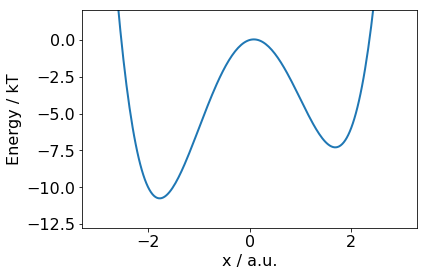

In [31]:
params = DoubleWell.params_default.copy()
params['dim'] = 2
double_well = DoubleWell(params=params)
double_well.plot_dimer_energy();

In [32]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [33]:
nsteps = 10000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

Text(0.5,0,'Probability')

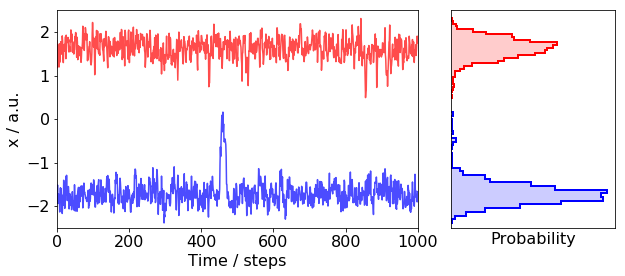

In [34]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(traj_left[:, 0], color='blue', alpha=0.7)
ax1.plot(traj_right[:, 0], color='red', alpha=0.7)
ax1.set_xlim(0, 1000)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('x / a.u.')
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Probability')

In [35]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

New NICER network - ML training
------

In [36]:
network = create_NICERNet(double_well, nl_activation='tanh')

In [37]:
hist = network.train_ML(x, xval=xval, epochs=150, batch_size=128, std=0.5)

Train on 2002 samples, validate on 2002 samples
Epoch 1/150
2002/2002 [==============================] - 3s 1ms/step - loss: 8.7118 - val_loss: 8.4535
Epoch 2/150
2002/2002 [==============================] - 0s 47us/step - loss: 6.4574 - val_loss: 8.1953
Epoch 3/150
2002/2002 [==============================] - 0s 48us/step - loss: 6.1853 - val_loss: 7.5620
Epoch 4/150
2002/2002 [==============================] - 0s 50us/step - loss: 6.0143 - val_loss: 7.4592
Epoch 5/150
2002/2002 [==============================] - 0s 49us/step - loss: 5.8558 - val_loss: 7.4394

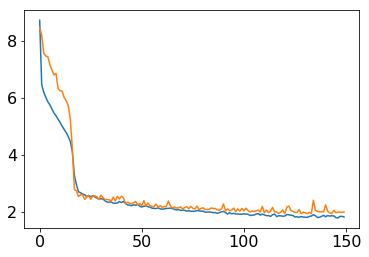

In [38]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [39]:
network.std_z(x)

0.47725022

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log


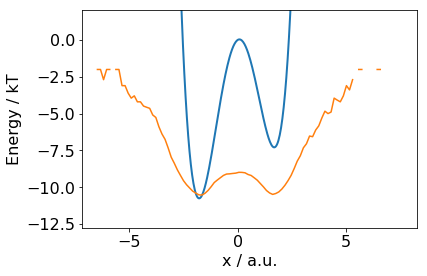

In [40]:
test_sample(network)

Transitions: 1935


D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log


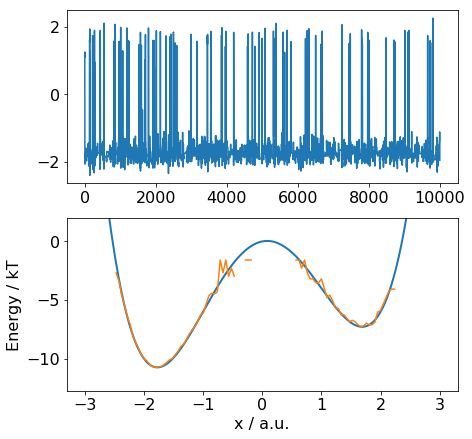

In [41]:
# test sampling
test_mcmc(network, 100000)

NICER Network - KL training
-----

In [42]:
hist = network.train_KL_wu(epochs=10000)

Epoch 0  loss 1.2938218
Epoch 1  loss 1.8277282
Epoch 2  loss 1.7130934
Epoch 3  loss 0.85407215
Epoch 4  loss 1.6553918
Epoch 5  loss 1.1808476
Epoch 6  loss 0.19593751
Epoch 7  loss 0.7537765
Epoch 8  loss 0.23001821
Epoch 9  loss 0.077010244
Epoch 10  loss -0.41703793
Epoch 11  loss -0.45853704
Epoch 12  loss 0.46368873
Epoch 13  loss 0.0025882097
Epoch 14  loss -0.06099425
Epoch 15  loss -0.48429483
Epoch 16  loss -0.62840956
Epoch 17  loss -0.16701122
Epoch 18  loss -0.67155683
Epoch 19  loss -0.25239325
Epoch 20  loss -1.2212738
Epoch 21  loss -0.6038282
Epoch 22  loss -0.69999003
Epoch 23  loss -1.1409285
Epoch 24  loss -0.7197798
Epoch 25  loss 0.053588897
Epoch 26  loss -1.0058764
Epoch 27  loss -1.0183634
Epoch 28  loss -0.7601223
Epoch 29  loss -0.59291595
Epoch 30  loss -0.603412
Epoch 31  loss -0.39746004
Epoch 32  loss -0.34999576
Epoch 33  loss -0.9722428
Epoch 34  loss -1.0280702
Epoch 35  loss -0.17259984
Epoch 36  loss -0.6142813
Epoch 37  loss -1.2521969
Epoch 38  lo

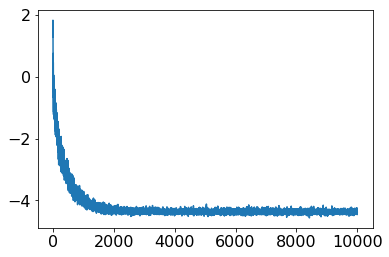

In [43]:
plt.plot(hist)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log


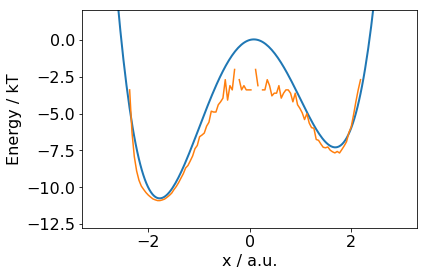

In [44]:
test_sample(network)

Transitions: 3984


D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log


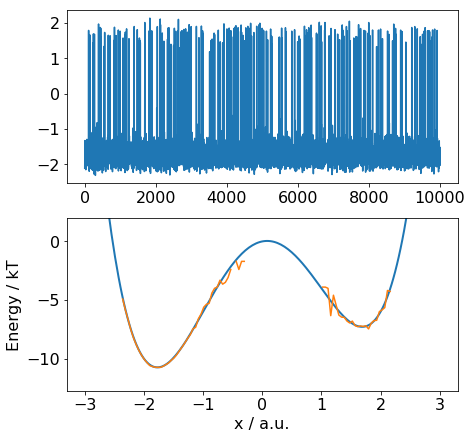

In [45]:
test_mcmc(network, 100000)